In [8]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from PIL import Image
import cv2
import glob
import os
import random

In [12]:
DIR_TRAIN_AND_VAL = '/home/taha/Downloads/Training_and_Validation-20241201T092920Z-001/Training_and_Validation/'
DIR_TEST = '/home/taha/Downloads/Testing-20241201T093441Z-001/Testing/'

In [16]:
def random_split(inList, ratio):
  random.shuffle(inList)
  split_point = int(len(inList) * ratio)
  train_imgs = inList[:split_point]
  val_imgs = inList[split_point:]
  return train_imgs, val_imgs

In [18]:
classes = os.listdir(DIR_TRAIN_AND_VAL)
print("Total Classes: ", len(classes))

train_and_val_imgs = []
train_imgs = []
val_imgs = []
test_imgs  = []
for _class in classes:
    train_and_val_imgs += glob.glob(DIR_TRAIN_AND_VAL + _class + '/*.jpg')
    test_imgs += glob.glob(DIR_TEST + _class + '/*.jpg')

train_imgs, val_imgs = random_split(train_and_val_imgs, 0.7)

print("\nTotal train images: ", len(train_imgs))
print("Total validation images: ", len(val_imgs))
print("Total test images: ", len(test_imgs))

Total Classes:  2

Total train images:  1282
Total validation images:  550
Total test images:  68


# Loading Dataset

In [ ]:
class WildfireDataset(Dataset):

    def __init__(self, imgs_list, classes, transforms):

        self.imgs_list = imgs_list
        self.class_to_int = {classes[i] : i for i in range(len(classes))}
        self.transforms = transforms


    def __getitem__(self, index):

        image_path = self.imgs_list[index]

        image = Image.open(image_path)

        label = image_path.split("/")[-2]
        label = self.class_to_int[label]

        image = self.transforms(image)

        return image, label


    def __len__(self):
        return len(self.imgs_list)

In [20]:
Transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize(mean=0.5, std=0.5)])

In [21]:
train_dataset = WildfireDataset(train_imgs, classes, Transforms)
test_dataset =  WildfireDataset(test_imgs, classes, Transforms)

# **Creating Dataloader**

In [ ]:
train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 18,
    num_workers = 8,
    shuffle = True
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = 18,
    num_workers = 8,
)

# Showing a sample

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([18, 3, 250, 250]), torch.Size([18]))

Image size: torch.Size([3, 250, 250])
Label: 0


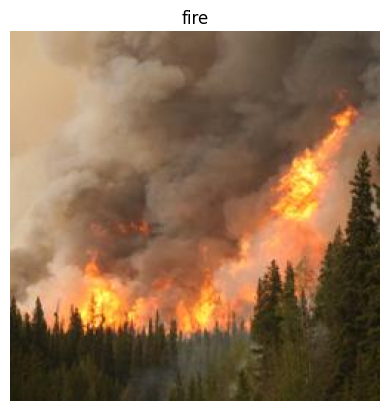

In [25]:
img, label = train_features_batch[0], train_labels_batch[0]
mean, std = 0.5, 0.5
img = std * img + mean
plt.imshow(img.permute((1,2,0)))
plt.title(classes[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}")

labels:
0 =  fire
1 = no fire

# CNN Class

In [ ]:
class CNN_Model(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.CNN_block = nn.Sequential(
            nn.Conv2d(input_shape,  hidden_units, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units*128*128, out_features = output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.CNN_block(x)
        x = self.classifier(x)
        # print(x.shape)
        return x


In [28]:
model = CNN_Model(input_shape=3, hidden_units=10, output_shape=len(classes))
model

CNN_Model(
  (CNN_block): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=156250, out_features=2, bias=True)
  )
)

In [ ]:
random_sample_grayscale = torch.randn((1, 1, 250, 250))
random_sample = random_sample_grayscale.repeat(1,3,1,1)
model(random_sample).shape

torch.Size([1, 2])

# Training

Training and Test functions

In [ ]:
def train_step(model,
               data_loader,
               loss_fn,
               optimizer,
               accuracy_fn,
               device):

    model.to(device)
    train_loss, train_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc ="  train") as train_tqdm:
        for X, y in train_tqdm:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss
            train_acc += accuracy_fn(true=y.cpu(),
                                     pred=y_pred.cpu())
            counter += 1
            train_tqdm.set_postfix(train_acc=train_acc/counter, train_loss=train_loss.item()/counter, refresh=True)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(data_loader)
        train_acc /= len(data_loader)

    return train_loss.item(), train_acc


In [ ]:
def test_step(model,
              data_loader,
              loss_fn,
              accuracy_fn,
              device):

    model.to(device)

    model.eval()
    test_loss, test_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for X, y in test_tqdm:
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(true=y.cpu(),
                                    pred=test_pred.cpu())
            counter += 1
            test_tqdm.set_postfix(train_acc=test_acc/counter, train_loss=test_loss.item()/counter, refresh=True)
 
        test_loss /= len(data_loader)
        test_acc  /= len(data_loader)

    return test_loss.item(), test_acc

# Training and Saving

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def accuracy_fn(true, pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

In [ ]:
from timeit import default_timer as timer

train_epoch_loss = []
train_epoch_accuracy = []
test_epoch_loss = []
test_epoch_accuracy = []

train_time_start = timer()

epochs = 20
for epoch in range(epochs):
    print("EPOCH {}/{} :".format(epoch +1, epochs))
    train_loss, train_acc = train_step(data_loader=train_dataloader,
                                              model=model,
                                              loss_fn=loss_fn,
                                              optimizer=optimizer,
                                              accuracy_fn=accuracy_fn,
                                              device=device
                                              )
    test_loss, test_acc = test_step(data_loader=test_dataloader,
                                    model=model,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device
                                    )

    train_epoch_loss.append(train_loss)
    train_epoch_accuracy.append(train_acc)
    test_epoch_loss.append(test_loss)
    test_epoch_accuracy.append(test_acc)

train_time_end = timer()
total_time = train_time_end - train_time_start
print(f"\n\nTrain time: {total_time:.3f} seconds")

EPOCH 1/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 14.02it/s, train_acc=87.1, train_loss=0.316]


EPOCH 2/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 14.09it/s, train_acc=88.5, train_loss=0.308]


EPOCH 3/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 13.30it/s, train_acc=90.3, train_loss=0.246]


EPOCH 4/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 15.14it/s, train_acc=86.7, train_loss=0.243]


EPOCH 5/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 13.91it/s, train_acc=87.5, train_loss=0.231]


EPOCH 6/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 13.05it/s, train_acc=91.3, train_loss=0.194]


EPOCH 7/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 13.02it/s, train_acc=88.5, train_loss=0.218]


EPOCH 8/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 14.85it/s, train_acc=88.9, train_loss=0.197]


EPOCH 9/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 13.90it/s, train_acc=89.9, train_loss=0.185]


EPOCH 10/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 12.73it/s, train_acc=88.9, train_loss=0.2]  


EPOCH 11/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 14.44it/s, train_acc=88.5, train_loss=0.205]


EPOCH 12/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 14.80it/s, train_acc=86.7, train_loss=0.278]


EPOCH 13/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 14.88it/s, train_acc=93.1, train_loss=0.179]


EPOCH 14/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 14.75it/s, train_acc=88.5, train_loss=0.194]


EPOCH 15/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 14.84it/s, train_acc=87.1, train_loss=0.225]


EPOCH 16/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 14.73it/s, train_acc=93.1, train_loss=0.219]


EPOCH 17/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 14.68it/s, train_acc=87.1, train_loss=0.234]


EPOCH 18/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 14.02it/s, train_acc=87.1, train_loss=0.249]


EPOCH 19/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 14.55it/s, train_acc=89.9, train_loss=0.217]


EPOCH 20/20 :


   test: 100%|██████████| 4/4 [00:00<00:00, 13.98it/s, train_acc=88.5, train_loss=0.228]



Train time: 34.783 seconds


In [33]:
torch.save(model.state_dict(), 'model-ff')

# Evaluation

#### Make prediction

In [ ]:
def make_predictions(model, data, device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    for sample in data:
        # Prepare sample
        sample = torch.unsqueeze(sample, dim=0).to(device)
        pred_logit = model(sample)

        pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

        pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [35]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [ ]:
pred_probs = make_predictions(model=model, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

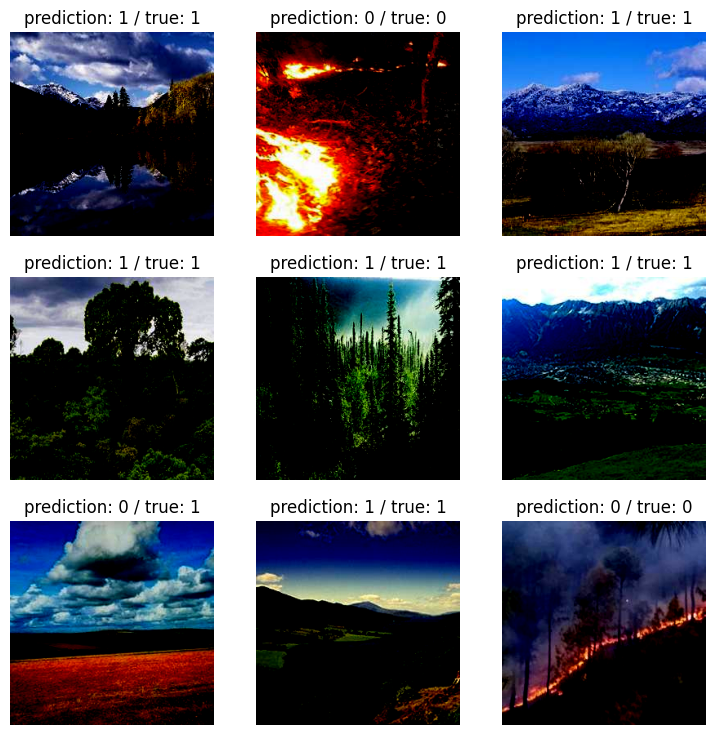

In [ ]:
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i in range(len(test_samples)):
    plt.subplot(nrows, ncols, i+1)
    sample = test_samples[i].numpy()
    sample = np.transpose(sample, (1,2,0))
    plt.imshow(sample)
    plt.title('prediction: {pred} / true: {true}'.format(pred = pred_classes[i], true = test_labels[i]))
    plt.axis('off')
plt.show()

#### Confusion Matrix

In [ ]:
y_preds = []
model.eval()
for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)

    y_logit = model(X)

    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 4/4 [00:00<00:00, 10.84it/s]


In [ ]:
from sklearn.metrics import confusion_matrix
y_true = []
for _, y in test_dataloader:
    y_true.append(y.cpu())
y_true_tensor = torch.cat(y_true)
y_pred_np = y_pred_tensor.numpy()
y_true_np = y_true_tensor.numpy()
cm = confusion_matrix(y_true_np, y_pred_np)
cm

array([[19,  3],
       [ 5, 41]])